In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import shelve
import numba as nb
import timeit
import shelve
import scipy

In [2]:
@nb.njit()
def frk1_step(y,u,h,w,K,F,N):
    y= y + h* Fkuramoto_nb(y, u, w,K,F,N)
    return ((y) % (2*math.pi))

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R1 +=np.cos(x[i])
        R2 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R1*np.sin(x[i])/N + K*R2*np.cos(x[i])/N +  F* np.sin(ut-x[i])
    return y


@nb.njit()
def whipeout(initlen, ut, x0, uin, h,w,K,F,L,N):
    for j in nb.prange(initlen):
        U1 = ut[j]
        for i in nb.prange(L):
            x  = frk1_step(x0,uin*U1,h,w,K,F,N)
            x0 = x
        
    return x

@nb.njit() 
def numba_norm(a):
    n = a.shape[0]
    norm = 0
    for i in range(n):
        norm += a[i] * a[i]
    return np.sqrt(norm)

@nb.njit()
def kura_run(runlen, ut, x0, uin, h,w,K,F,L,N):
    X = np.empty((N,runlen))
    for j in nb.prange(runlen):
        U1 = ut[j]
        for i in nb.prange(L):
            x  = frk1_step(x0,uin*U1,h,w,K,F,N)
            x0 = x
        X[:,j] = x
    return X

@nb.njit()
def NMSE(yeval,ydata):
    
    nmse = 0
    
    for j in nb.prange(yeval.shape[0]):
        nmse += (ydata[j]-yeval[j])**2
    nmse=nmse/numba_norm(ydata[:])**2
    return nmse

In [3]:
#load parameters and data

with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data_dict = shelf['narma'] 

with shelve.open('shelve/param.shelve', 'r') as shelf:
    p_dict = shelf['narma10'] 


In [4]:
ut = data_dict['input']
y = data_dict['output']

initlen = p_dict['init']
trainlen = p_dict['train']
testlen = p_dict['test']

N=p_dict['N']
L= p_dict['L']
h =  p_dict['h']
uin = p_dict['uin']
w=p_dict['w'][:N]
order=p_dict['order']
reg=p_dict['reg']
K = p_dict['K']
F = p_dict['F']


Text(0, 0.5, 'testing')

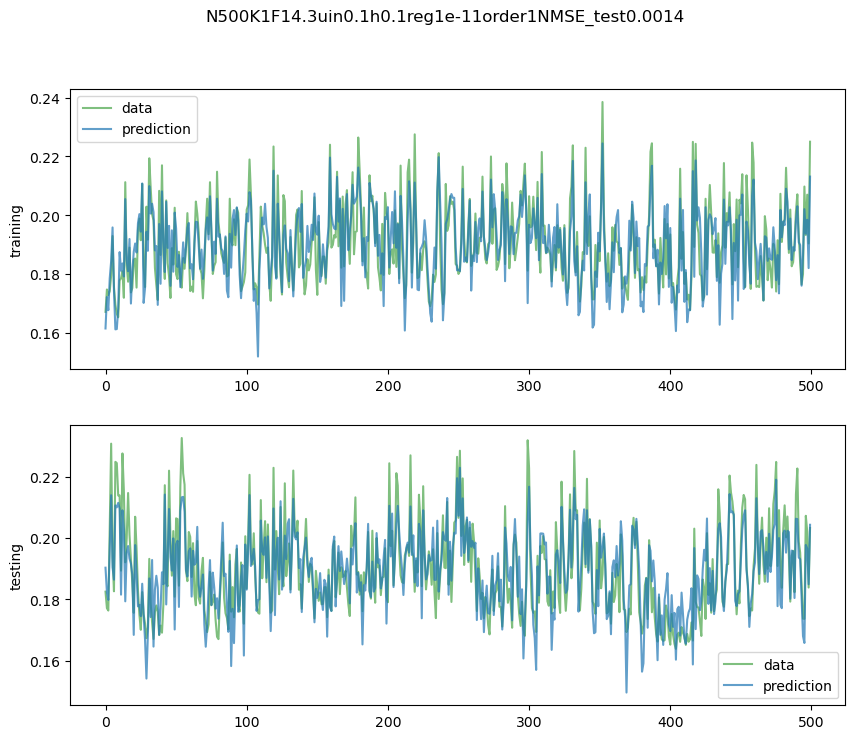

In [5]:

xint0 = np.linspace(0,2*math.pi,N) 
x=whipeout(initlen, ut, xint0, uin, h,w,K,F,L,N)
X_full= kura_run(trainlen + testlen, ut[initlen:], x, uin, h,w,K,F,L,N)
X0 = X_full[:,:trainlen]
X = np.concatenate( (np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0) ) ,axis=0)
Yt = y[(initlen):(initlen+trainlen)].T

Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(N+1) , np.dot(X,Yt) ).T
pred = (Wout @ X)

X_test = X_full[:,trainlen:]
X1 = np.concatenate((np.expand_dims(np.ones(X_test.shape[1]),axis=0),np.sin(X_test)),axis=0)

Y1 = y[(initlen+trainlen):(initlen+trainlen+testlen)].T
pred_test = Wout @ X1

NMSE_test =   NMSE(pred_test,Y1) 
NMSE_train =    NMSE(pred,Yt) 

fig, ax = plt.subplots(2, 1,figsize=(10,8))
fig.suptitle(f'N{N}K{K}F{F}uin{uin}h{h}reg{reg}order{order}NMSE_test{np.round(NMSE_test,4)}')

ax[0].plot(Yt[:500],label='data',alpha=0.5,color='green')
ax[0].plot(pred[:500], label='prediction',alpha=0.7,c='C0')
ax[0].legend() 
ax[0].set_ylabel('training')
ax[1].plot(Y1[:500],label='data',alpha=0.5,color='green')
ax[1].plot(pred_test[:500], label='prediction',alpha=0.7,c='C0')
ax[1].legend()
ax[1].set_ylabel('testing')

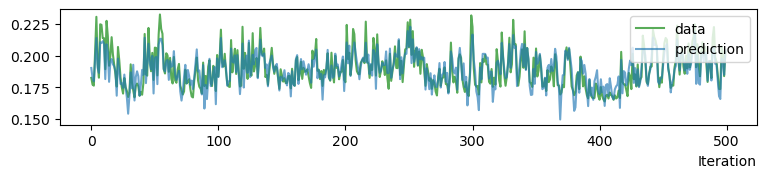

In [6]:
fig = plt.figure(figsize=(9,1.5))
plt.plot(Y1[:500],label='data',alpha=0.65,color='green')
plt.plot(pred_test[:500], label='prediction',alpha=0.65,c='C0')
plt.xlabel('Iteration', loc='right')
plt.legend(loc='upper right')
plt.savefig(f'Pictures_paper/narma10.jpg',dpi=600,bbox_inches = 'tight')


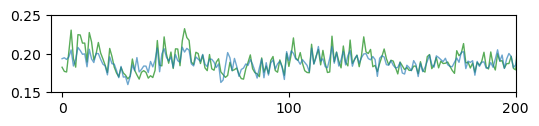

In [38]:
fig = plt.figure(figsize=(6,1))
plt.plot(Y1[:500],linewidth=1,label='data',alpha=0.65,color='green')
plt.plot(pred_test[:500],linewidth=1, label='prediction',alpha=0.65,c='C0')
#plt.xlabel('Iteration', loc='right')
#plt.legend(loc='upper right')
plt.xticks([0,100,200,300,400,500])
plt.axis([-5,200,0.15,0.25])
plt.savefig(f'Pictures_paper/narma10.jpg',dpi=600,bbox_inches = 'tight')


In [ ]:
rrrr

In [7]:
## random intial conditions
np.random.seed(0)
NMSE_list = [] 
initlen=5_000
for _ in range(10):
    xint0 = (np.random.rand(N)*2*np.pi) % (2*np.pi)
    x=whipeout(initlen, ut, xint0, uin, h,w,K,F,L,N)
    X_full= kura_run(trainlen + testlen, ut[initlen:], x, uin, h,w,K,F,L,N)
    X0 = X_full[:,:trainlen]
    X = np.concatenate( (np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0) ) ,axis=0)
    Yt = y[(initlen):(initlen+trainlen)].T

    Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(N+1) , np.dot(X,Yt) ).T
    pred = (Wout @ X)

    X_test = X_full[:,trainlen:]
    X1 = np.concatenate((np.expand_dims(np.ones(X_test.shape[1]),axis=0),np.sin(X_test)),axis=0)

    Y1 = y[(initlen+trainlen):(initlen+trainlen+testlen)].T
    pred_test = Wout @ X1

    NMSE_test =   NMSE(pred_test,Y1) 
    NMSE_train =    NMSE(pred,Yt) 
    NMSE_list.append(NMSE_test)

print(np.mean(NMSE_list), np.std(NMSE_list))

0.0019639231704614776 0.0007600454503236347


In [8]:
## let's reduce the size to N is 100

ut = data_dict['input']
y = data_dict['output']

initlen = p_dict['init']
trainlen = p_dict['train']
testlen = p_dict['test']

L= p_dict['L']
h =  p_dict['h']
w=p_dict['w'][:N]
order=p_dict['order']
reg=p_dict['reg']
K = p_dict['K']
F = p_dict['F']
N=100

uin=0.15

Text(0, 0.5, 'testing')

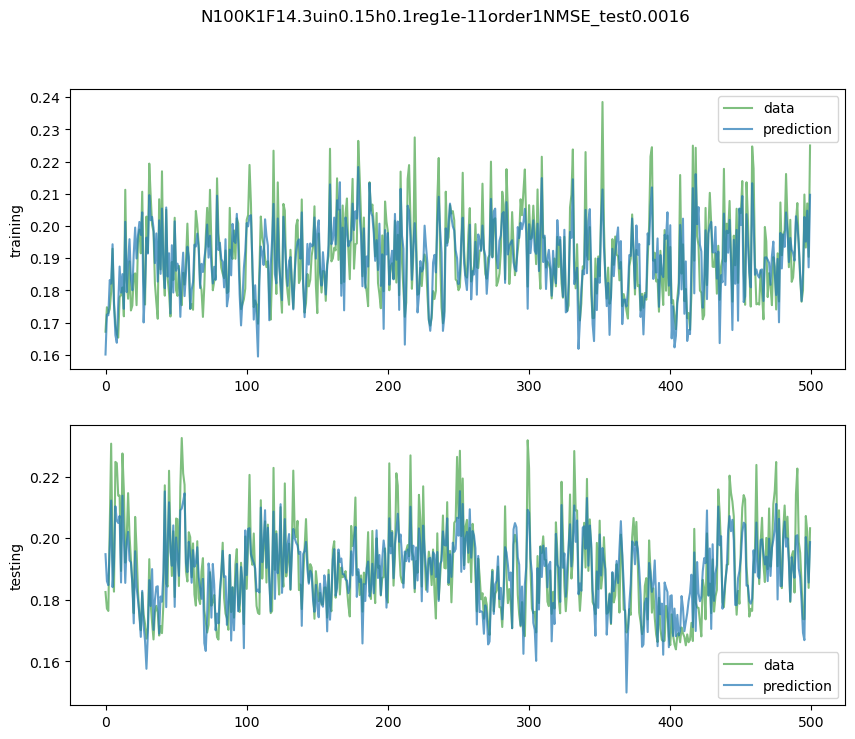

In [9]:

xint0 =  np.linspace(0,2*math.pi,N) 
x=whipeout(initlen, ut, xint0, uin, h,w,K,F,L,N)
X_full= kura_run(trainlen + testlen, ut[initlen:], x, uin, h,w,K,F,L,N)
X0 = X_full[:,:trainlen]
X = np.concatenate( (np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0) ) ,axis=0)
Yt = y[(initlen):(initlen+trainlen)].T

Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(N+1) , np.dot(X,Yt) ).T
pred = (Wout @ X)

X_test = X_full[:,trainlen:]
X1 = np.concatenate((np.expand_dims(np.ones(X_test.shape[1]),axis=0),np.sin(X_test)),axis=0)

Y1 = y[(initlen+trainlen):(initlen+trainlen+testlen)].T
pred_test = Wout @ X1

NMSE_test =   NMSE(pred_test,Y1) 
NMSE_train =    NMSE(pred,Yt) 

fig, ax = plt.subplots(2, 1,figsize=(10,8))
fig.suptitle(f'N{N}K{K}F{F}uin{uin}h{h}reg{reg}order{order}NMSE_test{np.round(NMSE_test,4)}')

ax[0].plot(Yt[:500],label='data',alpha=0.5,color='green')
ax[0].plot(pred[:500], label='prediction',alpha=0.7,c='C0')
ax[0].legend() 
ax[0].set_ylabel('training')
ax[1].plot(Y1[:500],label='data',alpha=0.5,color='green')
ax[1].plot(pred_test[:500], label='prediction',alpha=0.7,c='C0')
ax[1].legend()
ax[1].set_ylabel('testing')

In [10]:
# N=100 Kuramo but for random parameters
NMSE_list = []
for _ in range(100):
    reg=1e-11
    F=np.round(np.random.uniform(14,15),2)
    K=1
    uin= np.round(np.random.uniform(0.1,0.2),2)

    xint0 = np.linspace(0,2*math.pi,N+1)[:N] 
    x=whipeout(initlen, ut, xint0, uin, h,w,K,F,L,N)
    X_full= kura_run(trainlen + testlen, ut[initlen:], x, uin, h,w,K,F,L,N)
    X0 = X_full[:,:trainlen]
    X = np.concatenate( (np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0) ) ,axis=0)
    Yt = y[(initlen):(initlen+trainlen)].T

    Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(N+1) , np.dot(X,Yt) ).T
    pred = (Wout @ X)

    X_test = X_full[:,trainlen:]
    X1 = np.concatenate((np.expand_dims(np.ones(X_test.shape[1]),axis=0),np.sin(X_test)),axis=0)

    Y1 = y[(initlen+trainlen):(initlen+trainlen+testlen)].T
    pred_test = Wout @ X1

    NMSE_test =   NMSE(pred_test,Y1) 
    NMSE_train =    NMSE(pred,Yt) 
    NMSE_list.append(NMSE_test)

In [11]:
min(NMSE_list)

0.0013944514417591166

In [511]:
## let's compare to discrete ESN

import numpy as np
import matplotlib.pyplot as plt

# Class of ESN (for a single task)
class ESN():
    def __init__(self,N,rho,sigma,p,pin,rseed=0):
        self.N,self.rho,self.sigma,self.p,self.pin = N,rho,sigma,p,pin
        np.random.seed(rseed)
        W = np.random.uniform(-1,1,(N,N))*(np.random.uniform(0,1,(N,N))<p)
        eigs = np.linalg.eigvals(W)
        self.W = rho*W/np.max(np.abs(eigs))
        np.random.seed(rseed+1)
        self.Win = np.random.uniform(-sigma,sigma,N)*(np.random.uniform(0,1,N)<pin)

    def run(self,u,f=np.tanh):
        T = len(u)
        X = np.ones((T,self.N))
        for t in range(1,T):
            X[t] = f(self.W @ X[t-1] + self.Win*u[t-1])
        return X

    def washout(self,X,y,Two):
        T = X.shape[0]-Two
        Xwo = np.hstack([X[Two:],np.ones((T,1))])
        ywo = y[Two:].reshape((T,1))
        return Xwo,ywo

    def linear_regression(self,Xwo,ywo,Ttrain, beta=10e-4):
        # Split time-series into training and evaluation phases
        Xtrain, Xeval = Xwo[:Ttrain], Xwo[Ttrain:]
        ytrain, yeval = ywo[:Ttrain], ywo[Ttrain:]
        # Calculate wout and output
        wout = np.linalg.inv( Xtrain.T @ Xtrain + beta*np.identity(self.N+1)) @ Xtrain.T @ ytrain
        #wout = np.linalg.pinv(Xtrain) @ ytrain
        yhat = Xeval @ wout
        # NRMSE
        error = NMSE(yhat.flatten(),yeval.flatten())
        return yeval.flatten(),yhat.flatten(),error



In [730]:
# we use a grid search as in the Nakajima-paper (see supp information)

Two,Ttrain,Teval = initlen,trainlen,testlen
T = Ttrain + Teval
nmse_list = []
for rho in np.arange(0.1,2.1,0.1):
    for sigma in [1,0.5,0.2,0.1,0.05,0.01,0.005,0.001]:
        esn_test = ESN(23,rho,sigma,1,1)
        X = esn_test.run(ut[:Two+Ttrain+Teval])
        Xwo,ywo = esn_test.washout(X,y[:Two+Ttrain+Teval],Two)
        yeval,yhat,nmse = esn_test.linear_regression(Xwo,ywo,Ttrain,beta=1e-10)
        nmse_list.append(nmse)

In [722]:
Two,Ttrain,Teval = initlen,trainlen,testlen
T = Ttrain + Teval
nmse_list = []
for rho in np.arange(0.1,2.1,0.1):
    for sigma in  [1,0.5,0.2,0.1,0.05,0.01,0.005,0.001]:
        esn_test = ESN(10,rho,sigma,1,1)
        X = esn_test.run(ut[:Two+Ttrain+Teval])
        Xwo,ywo = esn_test.washout(X,y[:Two+Ttrain+Teval],Two)
        yeval,yhat,nmse = esn_test.linear_regression(Xwo,ywo,Ttrain,beta=1e-20)
        nmse_list.append(nmse)

In [723]:
min(nmse_list)

0.001577787674576384